In [1]:
%matplotlib inline

In [2]:
import os
import time
import datetime

import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout,LSTM, SimpleRNN, GRU, Bidirectional, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras import regularizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Stock Market Predictor Base Models

# Preprocessing Data

## 1. Read and visualisation data

In [3]:
START_DATE = "2013-01-02"
END_DATE = "2021-12-31"
SPLIT_FACTOR = 0.85

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
stocks_data = pd.read_csv(r'data\stocks_df.csv', header=0, sep = ",", parse_dates=[0], date_parser=parser)
mask = (stocks_data['Date'] >= START_DATE) & (stocks_data['Date'] <= END_DATE)
stocks_df = stocks_data.loc[mask]
stocks_df.reset_index(inplace = True, drop = True)
stocks_df

,Date,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,GBPUSD=X,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,2013-01-02,1462.420044,13412.54980,3112.260010,8632.009766,14.680000,2269.127930,1.319784,86.599998,1.624695,...,69.449501,20.130396,22.521328,28.374767,30.915403,93.433762,25.615805,13.006111,1.64,1.30
1,2013-01-03,1459.369995,13391.36035,3100.570068,8607.790039,14.560000,2269.127930,1.318218,87.275002,1.625250,...,69.842514,20.141891,22.751579,28.646267,30.624966,93.433762,25.282818,13.007962,1.62,1.28
2,2013-01-04,1466.469971,13435.20996,3101.659912,8667.679688,13.830000,2276.991943,1.303271,87.739998,1.608234,...,69.241432,20.262678,22.973143,28.675886,30.394314,94.064522,25.227316,13.072507,1.63,1.31
3,2013-01-07,1461.890015,13384.29004,3098.810059,8636.910156,13.790000,2285.364014,1.306745,88.197998,1.606787,...,70.058296,20.354708,23.007896,28.675886,29.693823,93.857025,25.306608,13.011653,1.62,1.28
4,2013-01-08,1457.150024,13328.84961,3091.810059,8604.379883,13.620000,2276.070068,1.312508,87.252998,1.612201,...,70.081436,20.010992,22.764624,28.473501,29.710911,94.512688,25.013260,13.149972,1.71,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,4791.189941,36302.37891,15871.259770,17141.089840,17.680000,3615.969971,1.132426,114.333000,1.340430,...,268.239990,24.286488,167.580002,327.197418,252.866135,343.420013,191.839996,91.320000,2.02,1.72
2263,2021-12-28,4786.350098,36398.21094,15781.719730,17134.160160,17.540001,3630.112061,1.133003,114.792000,1.344267,...,267.880005,24.325691,166.419998,323.230011,253.185089,343.790008,191.100006,91.879997,1.93,1.63
2264,2021-12-29,4793.060059,36488.62891,15766.219730,17149.929690,16.950001,3597.000000,1.131478,114.773003,1.343328,...,268.489990,24.149275,168.779999,326.579987,256.723419,345.399994,190.809998,91.989998,1.96,1.67
2265,2021-12-30,4778.729980,36398.07813,15741.559570,17164.240230,17.330000,3619.189941,1.136015,114.947998,1.349879,...,267.209992,24.286488,167.490005,328.470001,255.547317,344.329987,189.410004,92.769997,2.00,1.73


In [6]:
company_data = pd.read_csv(r'data\company_dataset_ts.csv', header=0, sep = ",", parse_dates=[0], date_parser=parser)
mask = (company_data['Date'] >= START_DATE) & (company_data['Date'] <= END_DATE)
company_df = company_data.loc[mask]
company_df.reset_index(inplace = True, drop = True)
company_df

,Date,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold
0,2013-01-02,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,21.725426,...,28.139999,28.670000,6677100.0,21.331152,21.544037,21.318136,67.940932,0.248235,28.276532,26.462801
1,2013-01-03,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,...,28.760000,28.440001,3970700.0,21.405943,21.617482,21.379340,64.147275,0.281482,28.441684,26.473316
2,2013-01-04,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,...,28.500000,29.219999,5842400.0,21.529171,21.782178,21.472446,70.220399,0.352791,28.711065,26.420268
3,2013-01-07,21.818907,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,...,29.100000,28.010000,8339200.0,21.555511,21.842271,21.520297,54.732007,0.329450,28.761600,26.540400
4,2013-01-08,22.075964,21.818907,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,...,27.930000,28.340000,3880400.0,21.602825,21.936860,21.580389,57.486147,0.327915,28.805516,26.614484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,64.849998,...,65.540001,66.070000,1175900.0,64.719121,65.231429,64.166191,58.105626,0.302337,66.388560,62.033441
2263,2021-12-28,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,...,66.000000,66.930000,1049900.0,64.920110,65.340001,64.286667,61.772180,0.438992,66.711888,61.891113
2264,2021-12-29,67.010002,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,...,67.050003,67.010002,1038500.0,65.110100,65.588573,64.391429,62.104439,0.547438,67.116617,61.917051
2265,2021-12-30,66.860001,67.010002,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,...,67.199997,66.860001,906900.0,65.269182,65.965716,64.612857,61.033303,0.614197,67.396706,62.084962


In [7]:
stocks_df[stocks_df.isna().any(axis=1)]

,Date,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,GBPUSD=X,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE


In [8]:
company_df[company_df.isna().any(axis=1)]

,Date,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold


In [9]:
stocks_df.shape, company_df.shape

((2267, 87), (2267, 44))

In [10]:
stocks_df.describe().T

,count,mean,std,min,25%,50%,75%,max
^GSPC,2267.0,2592.580396,781.401906,1457.150024,2020.714966,2432.459961,2935.729981,4793.060059
^DJI,2267.0,22382.318566,5996.247598,13328.849610,17323.235355,21328.470700,26327.334960,36488.628910
^IXIC,2267.0,7115.422644,3284.071455,3091.810059,4727.080079,6234.410156,8118.175049,16057.440430
^NYA,2267.0,11933.662107,1996.464400,8604.379883,10515.500000,11514.400390,12884.955075,17310.509770
^VIX,2267.0,17.000362,7.122941,9.140000,12.840000,14.910000,18.884999,82.690002
...,...,...,...,...,...,...,...,...
LIN,2267.0,152.325847,64.350183,85.154175,105.852566,121.700264,184.508926,346.429993
TXN,2267.0,85.135160,48.235800,25.013260,43.962057,72.645607,111.169167,201.289993
NEE,2267.0,38.130828,21.319112,13.006111,20.255817,31.979395,53.418072,93.360001
T10YIE,2267.0,2.171544,0.453418,0.040000,2.020000,2.320000,2.440000,2.760000


In [11]:
company_df.iloc[:, 32:].describe().T

,count,mean,std,min,25%,50%,75%,max
High,2267.0,4.503447e+01,7.657740e+00,28.360001,4.085000e+01,4.383000e+01,4.827500e+01,6.930000e+01
Low,2267.0,4.422260e+01,7.582431e+00,27.900000,4.016000e+01,4.317000e+01,4.741500e+01,6.846000e+01
Open,2267.0,4.462786e+01,7.629530e+00,27.930000,4.049500e+01,4.350000e+01,4.789500e+01,6.890000e+01
Close,2267.0,4.463629e+01,7.616271e+00,28.010000,4.051000e+01,4.351000e+01,4.790000e+01,6.877000e+01
Volume,2267.0,3.441749e+06,1.527734e+06,411600.000000,2.394800e+06,3.059500e+06,4.073400e+06,1.580600e+07
ewm,2267.0,3.931158e+01,8.790396e+00,21.331152,3.545468e+01,3.804518e+01,4.145121e+01,6.617754e+01
ma_7,2267.0,3.944639e+01,8.920868e+00,21.544037,3.523192e+01,3.815702e+01,4.161527e+01,6.755831e+01
ma_21,2267.0,3.931136e+01,8.816601e+00,21.318136,3.536850e+01,3.814080e+01,4.142848e+01,6.649386e+01
rsi,2267.0,5.329094e+01,1.193041e+01,17.612588,4.590389e+01,5.342373e+01,6.184395e+01,8.412706e+01
macd,2267.0,1.349350e-01,6.238122e-01,-2.827388,-1.411524e-01,1.662251e-01,5.097131e-01,2.376329e+00


In [12]:
corr = company_df.iloc[:, 32:].corr()
corr.style.background_gradient(cmap='coolwarm')

,High,Low,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold
High,1.000000,0.998552,0.998900,0.998817,-0.289261,0.945246,0.953304,0.941304,0.164937,0.302025,0.966090,0.970226
Low,0.998552,1.000000,0.998783,0.998879,-0.313850,0.940437,0.949398,0.936317,0.177053,0.313006,0.961181,0.970053
Open,0.998900,0.998783,1.000000,0.997514,-0.300973,0.943837,0.952307,0.939888,0.159626,0.306421,0.964821,0.971226
Close,0.998817,0.998879,0.997514,1.000000,-0.302737,0.941945,0.950543,0.937814,0.181961,0.308971,0.962174,0.968840
Volume,-0.289261,-0.313850,-0.300973,-0.302737,1.000000,-0.305286,-0.314495,-0.300841,-0.145541,-0.177068,-0.242470,-0.289600
ewm,0.945246,0.940437,0.943837,0.941945,-0.305286,1.000000,0.996247,0.999240,0.014685,0.174515,0.947337,0.935419
ma_7,0.953304,0.949398,0.952307,0.950543,-0.314495,0.996247,1.000000,0.993461,0.082388,0.255090,0.939418,0.931786
ma_21,0.941304,0.936317,0.939888,0.937814,-0.300841,0.999240,0.993461,1.000000,-0.004981,0.159061,0.949391,0.937454
rsi,0.164937,0.177053,0.159626,0.181961,-0.145541,0.014685,0.082388,-0.004981,1.000000,0.797336,-0.028424,0.008555
macd,0.302025,0.313006,0.306421,0.308971,-0.177068,0.174515,0.255090,0.159061,0.797336,1.000000,0.128380,0.183394


In [13]:
corr = stocks_df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [14]:
num_training_days = int(company_df.shape[0]*SPLIT_FACTOR)
split_point = company_df[num_training_days: num_training_days+1].values[0][0]
year = split_point.year
month = split_point.month
day = split_point.day
print(f"Number of training days: {num_training_days}. Number of test days: {company_df.shape[0]-num_training_days}.")
print(f"Split date is: {split_point}. Index is: {company_df[num_training_days: num_training_days+1].index.values[0]}")

Number of training days: 1926. Number of test days: 341.
Split date is: 2020-08-26 00:00:00. Index is: 1926


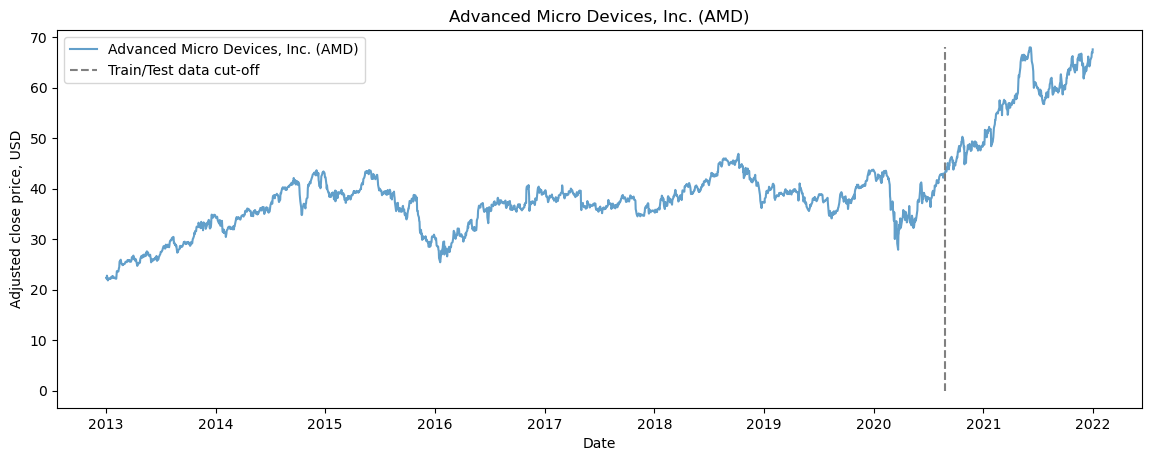

In [15]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(company_df['Date'], company_df['Adj Close'], label='Advanced Micro Devices, Inc. (AMD)', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
plt.show()

In [16]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(3, 1, 1)
    plt.plot(dataset['ma_7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['ma_21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['Adj Close'],label='Adj Close', color='b')
    plt.plot(dataset['bolu'],label='Bollinger Upper Band', color='c')
    plt.plot(dataset['bold'],label='Bollinger Lower Band', color='c')
    plt.fill_between(x_, dataset['bolu'], dataset['bold'], alpha=0.35)
    plt.title('Technical indicators for Advanced Micro Devices, Inc. (AMD) - last {} days.'.format(last_days))
    plt.ylabel('Adjusted close price, USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(3, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['macd'],label='MACD', linestyle='-.')
    plt.hlines(5, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-5, xmacd_, shape_0, colors='g', linestyles='--')
    plt.legend()
    
    # Plot tirth subplot
    plt.subplot(3, 1, 3)
    plt.title('RSI')
    plt.plot(dataset['rsi'],label='RSI', color='b',linestyle='-')
    plt.legend()
    
    plt.show()

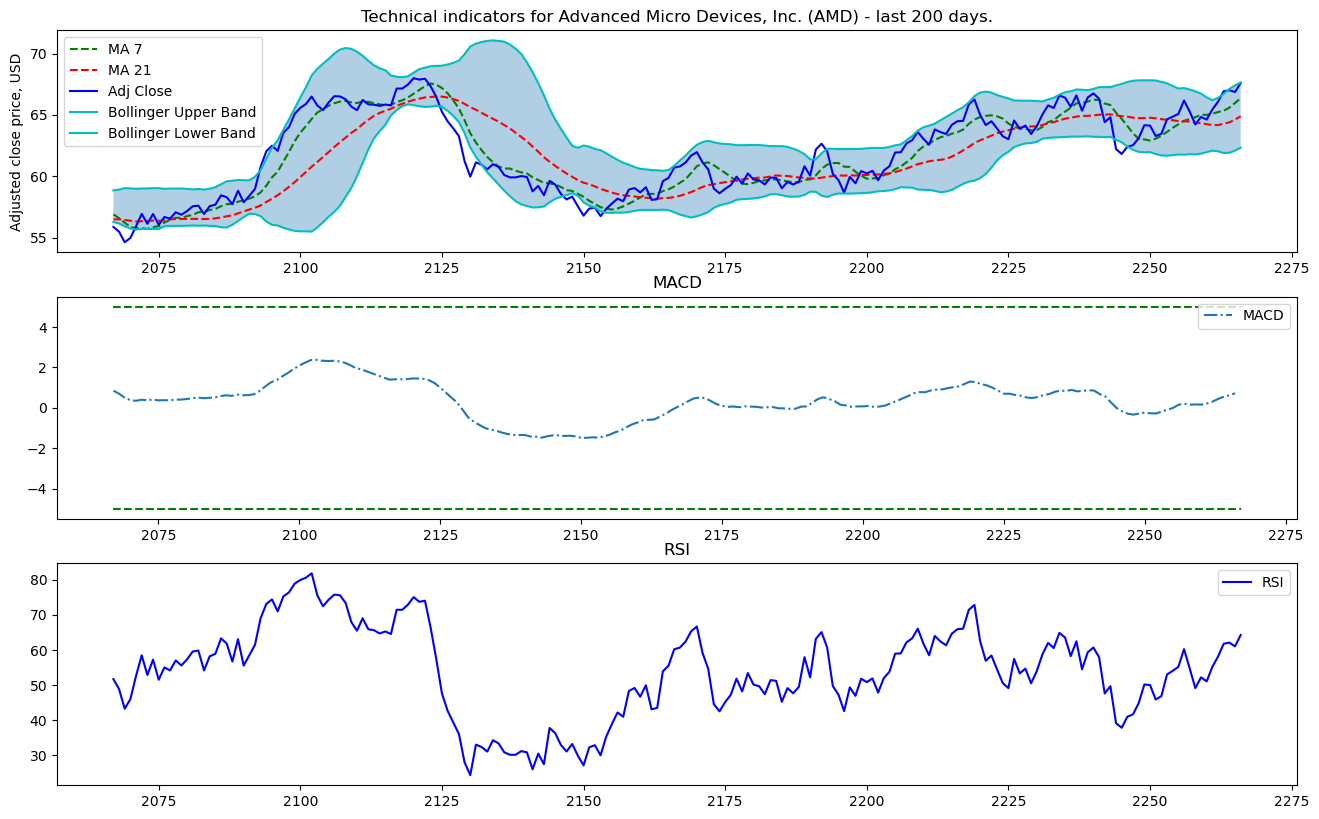

In [17]:
plot_technical_indicators(company_df, 200)

In [18]:
print('Total dataset for company has {} samples, and {} features.'.format(company_df.shape[0], company_df.shape[1]))
print('Total dataset for other market features has {} samples, and {} features.'.format(stocks_df.shape[0], stocks_df.shape[1]))

Total dataset for company has 2267 samples, and 44 features.
Total dataset for other market features has 2267 samples, and 87 features.


In [19]:
full_df = company_df.merge(stocks_df, left_index=True,right_index=True)
full_df.shape

(2267, 131)

In [20]:
full_df = full_df.drop(labels=["Date_x", "Date_y"], axis=1)
full_df

,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,21.725426,21.873428,...,69.449501,20.130396,22.521328,28.374767,30.915403,93.433762,25.615805,13.006111,1.64,1.30
1,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,21.725426,...,69.842514,20.141891,22.751579,28.646267,30.624966,93.433762,25.282818,13.007962,1.62,1.28
2,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,21.834482,...,69.241432,20.262678,22.973143,28.675886,30.394314,94.064522,25.227316,13.072507,1.63,1.31
3,21.818907,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,21.639740,...,70.058296,20.354708,23.007896,28.675886,29.693823,93.857025,25.306608,13.011653,1.62,1.28
4,22.075964,21.818907,22.761452,22.153860,22.333015,21.335943,21.078882,21.413837,21.398258,21.608580,...,70.081436,20.010992,22.764624,28.473501,29.710911,94.512688,25.013260,13.149972,1.71,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,64.849998,64.639999,...,268.239990,24.286488,167.580002,327.197418,252.866135,343.420013,191.839996,91.320000,2.02,1.72
2263,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,64.849998,...,267.880005,24.325691,166.419998,323.230011,253.185089,343.790008,191.100006,91.879997,1.93,1.63
2264,67.010002,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,65.080002,...,268.489990,24.149275,168.779999,326.579987,256.723419,345.399994,190.809998,91.989998,1.96,1.67
2265,66.860001,67.010002,66.930000,66.070000,65.440002,64.620003,64.830002,64.220001,65.269997,66.169998,...,267.209992,24.286488,167.490005,328.470001,255.547317,344.329987,189.410004,92.769997,2.00,1.73


## 2. Normalize Data

In [21]:
def min_max_normalize_inverse_transform(data, MIN, MAX):
    i_data = data * (MAX - MIN)+ MIN
    return i_data

In [22]:
def min_max_normalize(data):
    n_data = (data - data.min()) / (data.max() - data.min())
    return n_data

In [23]:
MIN = full_df["Adj Close"].min(axis=0)
MAX = full_df["Adj Close"].max(axis=0)
MIN, MAX

(21.818906784057617, 67.9862289428711)

In [24]:
full_df_scaled = min_max_normalize(full_df)
full_df_scaled

,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,0.011136,0.000000,0.000000,0.007141,0.006809,0.011292,0.011957,0.016108,0.013783,0.016939,...,0.001044,0.057023,0.000000,0.000000,0.005292,0.031689,0.003418,0.000000,0.588235,0.683398
1,0.007255,0.021373,0.005480,0.000000,0.007141,0.006809,0.011292,0.011957,0.016108,0.013783,...,0.003017,0.057853,0.001489,0.000894,0.004034,0.031689,0.001529,0.000023,0.580882,0.679537
2,0.020416,0.017533,0.026736,0.005480,0.000000,0.007141,0.006809,0.011292,0.011957,0.016108,...,0.000000,0.066579,0.002921,0.000992,0.003035,0.034103,0.001214,0.000826,0.584559,0.685328
3,0.000000,0.030557,0.022917,0.026736,0.005480,0.000000,0.007141,0.006809,0.011292,0.011957,...,0.004100,0.073227,0.003146,0.000992,0.000000,0.033309,0.001664,0.000069,0.580882,0.679537
4,0.005568,0.010353,0.035870,0.022917,0.026736,0.005480,0.000000,0.007141,0.006809,0.011292,...,0.004216,0.048397,0.001573,0.000325,0.000074,0.035819,0.000000,0.001790,0.613971,0.689189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,0.958494,0.945419,0.928237,0.932714,0.919709,0.942094,0.961280,0.938043,0.933140,0.928663,...,0.998745,0.357262,0.937858,0.984232,0.966838,0.988480,0.946391,0.974612,0.727941,0.764479
2263,0.977122,0.958924,0.945718,0.928237,0.932714,0.919709,0.942094,0.961280,0.938043,0.933140,...,0.996939,0.360094,0.930358,0.971165,0.968219,0.989896,0.942193,0.981581,0.694853,0.747104
2264,0.978855,0.977359,0.959149,0.945718,0.928237,0.932714,0.919709,0.942094,0.961280,0.938043,...,1.000000,0.347349,0.945616,0.982199,0.983548,0.996058,0.940548,0.982950,0.705882,0.754826
2265,0.975606,0.979074,0.977483,0.959149,0.945718,0.928237,0.932714,0.919709,0.942094,0.961280,...,0.993576,0.357262,0.937276,0.988424,0.978453,0.991962,0.932606,0.992657,0.720588,0.766409


In [25]:
#test inverse_transform
test_number = sum(min_max_normalize_inverse_transform(full_df_scaled["Adj Close"], MIN, MAX))- sum(full_df["Adj Close"])
test_number

0.0

In [28]:
# full_df_scaled.min(), full_df_scaled.max()

## 3. Split Data

In [26]:
num_train_samples = int((SPLIT_FACTOR) * len(full_df_scaled))
num_test_samples = len(full_df_scaled) - num_train_samples
num_train_samples, num_test_samples

(1926, 341)

In [27]:
full_df_train = full_df_scaled.iloc[0:num_train_samples, 0:]
full_df_test = full_df_scaled.iloc[num_train_samples:, 0:]
full_df_train.shape, full_df_test.shape

((1926, 129), (341, 129))

## 4. Shift Data

In [28]:
full_df_train = full_df_train.sample(frac=1, random_state=42)
full_df_train

,Adj Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
1075,0.370773,0.375432,0.385497,0.385682,0.388449,0.395645,0.400073,0.401364,0.403763,0.394169,...,0.234409,0.717988,0.192403,0.183665,0.198370,0.093104,0.262066,0.198730,0.838235,0.876448
1650,0.342869,0.349075,0.349477,0.346905,0.345125,0.348092,0.358182,0.376383,0.379944,0.376185,...,0.659273,0.586111,0.402653,0.372070,0.299251,0.419409,0.547590,0.459295,0.525735,0.590734
1861,0.300681,0.271852,0.270513,0.275227,0.264363,0.277072,0.242982,0.243794,0.237300,0.255563,...,0.542869,0.525273,0.470264,0.425820,0.393681,0.393299,0.494504,0.542277,0.816176,0.812741
941,0.301406,0.308821,0.322975,0.332249,0.329158,0.317155,0.317701,0.314973,0.319519,0.314063,...,0.167929,0.698746,0.192832,0.155171,0.152275,0.078823,0.203489,0.175385,0.955882,0.942085
331,0.297018,0.304983,0.312376,0.314083,0.312034,0.316813,0.319374,0.319032,0.306231,0.313400,...,0.056552,0.176952,0.062559,0.026388,0.047172,0.095700,0.071327,0.070914,0.871324,0.884170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.304503,0.309086,0.318450,0.315847,0.313430,0.317520,0.321796,0.339644,0.341875,0.338157,...,0.347621,0.590176,0.184041,0.179643,0.178231,0.145127,0.254071,0.233793,0.878676,0.905405
1294,0.334984,0.348759,0.360893,0.371552,0.366508,0.340445,0.331380,0.330058,0.334213,0.331569,...,0.384908,0.588307,0.271917,0.221376,0.263044,0.221806,0.394862,0.270993,0.841912,0.866795
860,0.325132,0.320495,0.323135,0.331444,0.328554,0.317897,0.310131,0.281051,0.270033,0.243663,...,0.182727,0.544555,0.186044,0.070225,0.187297,0.051642,0.158661,0.154593,0.948529,0.957529
1459,0.489237,0.499766,0.497488,0.493433,0.490344,0.518726,0.544020,0.550585,0.536683,0.524905,...,0.427238,0.456332,0.334021,0.247567,0.289487,0.252601,0.388597,0.333645,0.819853,0.833977


## 5. Reshape Data

In [29]:
company_df.shape, stocks_df.shape

((2267, 44), (2267, 87))

In [30]:
X_train_company = full_df_train.iloc[:, 1:company_df.shape[1]-1]
y_train_company = full_df_train.iloc[:, 0]
X_test_company = full_df_test.iloc[:, 1:company_df.shape[1]-1]
y_test_company = full_df_test.iloc[:, 0]

X_train_stocks = full_df_train.iloc[:, company_df.shape[1]-1:]
y_train_stocks = full_df_train.iloc[:, 0]
X_test_stocks = full_df_test.iloc[:, company_df.shape[1]-1:]
y_test_stocks = full_df_test.iloc[:, 0]

In [31]:
X_train_company.shape, y_train_company.shape, X_test_company.shape, y_test_company.shape

((1926, 42), (1926,), (341, 42), (341,))

In [32]:
X_train_company = X_train_company.to_numpy().reshape(X_train_company.shape[0], 1, X_train_company.shape[1])
y_train_company = y_train_company.to_numpy()
X_test_company = X_test_company.to_numpy().reshape(X_test_company.shape[0], 1, X_test_company.shape[1])
y_test_company = y_test_company.to_numpy()

In [33]:
X_train_stocks = X_train_stocks.to_numpy().reshape(X_train_stocks.shape[0], 1, X_train_stocks.shape[1])
y_train_stocks = y_train_stocks.to_numpy()
X_test_stocks = X_test_stocks.to_numpy().reshape(X_test_stocks.shape[0], 1, X_test_stocks.shape[1])
y_test_stocks = y_test_stocks.to_numpy()

In [34]:
X_train_company.shape, y_train_company.shape, X_test_company.shape, y_test_company.shape

((1926, 1, 42), (1926,), (341, 1, 42), (341,))

In [35]:
X_train_stocks.shape, y_train_stocks.shape, X_test_stocks.shape, y_test_stocks.shape

((1926, 1, 86), (1926,), (341, 1, 86), (341,))

# MODELING DATA

In [36]:
def plot_history_loss(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'], c="green")
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')   
        
    plt.grid(True)

In [37]:
def plot_mae(history):
    plt.figure()    
    plt.plot(history.history['mae'], c="red") 
    plt.plot(history.history['val_mae'], c="green")
    plt.legend(['train_mae', 'val_mae'], loc='upper left')
    plt.title('Model Metrics')
    plt.ylabel('MAE')
    plt.xlabel('Epoch') 
      
    plt.grid(True)

In [38]:
# https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction
# https://stackabuse.com/custom-keras-callback-for-saving-prediction-on-each-epoch-with-visualizations/

def compile_fit_model(X_train,y_train, checkpoint_name, model, optimizer, epochs, batch_size, validation_split):
    callbacks = [ModelCheckpoint(checkpoint_name, monitor="mae", mode="min", save_best_only=True)]
    model.compile(optimizer= optimizer, loss="mse", metrics=["mae"])
    history = model.fit(
                        X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        callbacks=callbacks,
                        )
    return model, history 
# monitor="val_mae", monitor="val_loss"

In [39]:
def evaluate_model(model, X_test, y_test):
    print(f"Test MAE: {model.evaluate(X_test, y_test)[1]:.2f}")

## 1. STOCKS Model - Architecture
### Many-to-One Model BiLSTM - stocks_dataset

In [506]:
tf.keras.backend.clear_session()

In [507]:
stocks_inputs = Input(shape=(1, X_train_stocks.shape [2]))
x = Bidirectional(LSTM(128, activation = "relu", return_sequences=True))(stocks_inputs)
x = Bidirectional(LSTM(64, activation = "relu", return_sequences=False))(x)
x = Dense(64, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
stocks_outputs = Dense(1, activation = "linear")(x)

# kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), kernel_regularizer="l2"
# kernel_initializer='glorot_uniform'
model_stocks = Model(stocks_inputs, stocks_outputs)

In [508]:
model_stocks.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 86)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 256)            220160    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

In [509]:
opt_adadelta = Adadelta(lr=0.01, rho=0.95, epsilon=1e-07, decay=0.0)
opt_adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
opt_rmsprop =RMSprop(learning_rate=1e-2, decay=0.1)
opt_rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
epochs = 90
batch_size = 128
validation_split = 0.0
callbacks_name = "stocks_predictor.keras"

In [510]:
model_stocks, history_stocks = compile_fit_model(X_train_stocks,y_train_company, \
                callbacks_name, model_stocks, opt_rms, epochs, batch_size, validation_split)

Epoch 1/90
16/16 [==============================] - 0s 11ms/step - loss: 1.0697 - mae: 0.6866
Epoch 2/90
16/16 [==============================] - 0s 12ms/step - loss: 0.3056 - mae: 0.3801
Epoch 3/90
16/16 [==============================] - 0s 11ms/step - loss: 0.2051 - mae: 0.3038
Epoch 4/90
16/16 [==============================] - 0s 12ms/step - loss: 0.1754 - mae: 0.2692
Epoch 5/90
16/16 [==============================] - 0s 11ms/step - loss: 0.1461 - mae: 0.2362
Epoch 6/90
16/16 [==============================] - 0s 12ms/step - loss: 0.1304 - mae: 0.2290
Epoch 7/90
16/16 [==============================] - 0s 11ms/step - loss: 0.1306 - mae: 0.2268
Epoch 8/90
16/16 [==============================] - 0s 12ms/step - loss: 0.1210 - mae: 0.2116
Epoch 9/90
16/16 [==============================] - 0s 12ms/step - loss: 0.1066 - mae: 0.1955
Epoch 10/90
16/16 [==============================] - 0s 11ms/step - loss: 0.1064 - mae: 0.1905
Epoch 11/90
16/16 [==============================] - 0s 12m

Epoch 34/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0512 - mae: 0.1144
Epoch 35/90
16/16 [==============================] - 0s 15ms/step - loss: 0.0493 - mae: 0.1162
Epoch 36/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0547 - mae: 0.1149
Epoch 37/90
16/16 [==============================] - 0s 16ms/step - loss: 0.0493 - mae: 0.1145
Epoch 38/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0423 - mae: 0.1088
Epoch 39/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0536 - mae: 0.1191
Epoch 40/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0521 - mae: 0.1120
Epoch 41/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0451 - mae: 0.1040
Epoch 42/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0503 - mae: 0.1113
Epoch 43/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0469 - mae: 0.1076
Epoch 44/90
16/16 [==============================]

16/16 [==============================] - 0s 13ms/step - loss: 0.0374 - mae: 0.0957
Epoch 67/90
16/16 [==============================] - 0s 11ms/step - loss: 0.0340 - mae: 0.0903
Epoch 68/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0335 - mae: 0.0893
Epoch 69/90
16/16 [==============================] - 0s 13ms/step - loss: 0.0340 - mae: 0.0881
Epoch 70/90
16/16 [==============================] - 0s 11ms/step - loss: 0.0343 - mae: 0.0901
Epoch 71/90
16/16 [==============================] - 0s 11ms/step - loss: 0.0396 - mae: 0.0932
Epoch 72/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0356 - mae: 0.0895
Epoch 73/90
16/16 [==============================] - 0s 11ms/step - loss: 0.0305 - mae: 0.0841
Epoch 74/90
16/16 [==============================] - 0s 12ms/step - loss: 0.0358 - mae: 0.0910
Epoch 75/90
16/16 [==============================] - 0s 11ms/step - loss: 0.0477 - mae: 0.0974
Epoch 76/90
16/16 [==============================] - 0s 13ms/s

In [511]:
print(f"Test MAE: {model_stocks.evaluate(X_test_stocks, y_test_company)[1]:.2f}")

11/11 [==============================] - 0s 2ms/step - loss: 0.0188 - mae: 0.0817
Test MAE: 0.08


In [1]:
# plt.figure()
# plt.hist(model_stocks.layers[6].kernel.numpy().ravel(), bins = "fd", facecolor='g', alpha=0.6)
# plt.figure()
# plt.hist(model_stocks.layers[9].kernel.numpy().ravel(), bins = "fd", facecolor='g', alpha=0.6)
# plt.show()

In [513]:
hist = pd.DataFrame(history_stocks.history)
hist['epoch'] = history_stocks.epoch
hist.tail()

,loss,mae,epoch
85,0.025737,0.079711,85
86,0.033166,0.086389,86
87,0.034376,0.086112,87
88,0.045095,0.092537,88
89,0.031176,0.085339,89


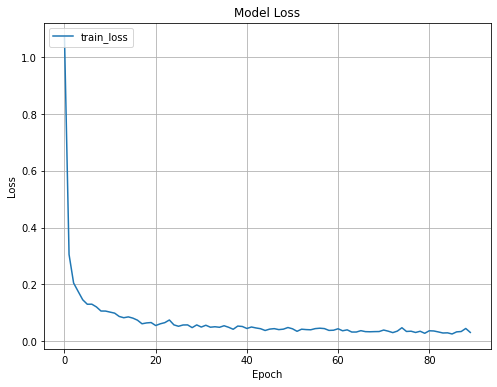

In [514]:
plt.figure()
plt.plot(history_stocks.history['loss'])
plt.legend(['train_loss'], loc='upper left')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.grid(True)

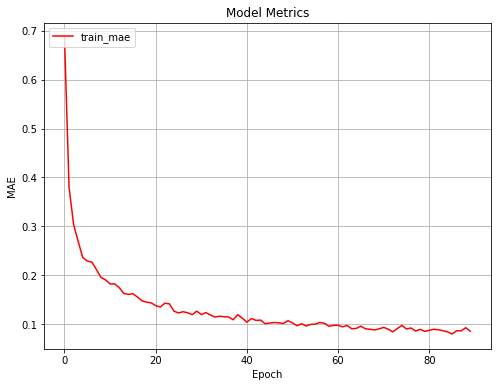

In [515]:
plt.figure()    
plt.plot(history_stocks.history['mae'], c="red") 
plt.legend(['train_mae'], loc='upper left')
plt.title('Model Metrics')
plt.ylabel('MAE')
plt.xlabel('Epoch') 
      
plt.grid(True)

In [516]:
predicted_stock_price = model_stocks.predict([X_test_stocks])

In [517]:
real_df = pd.DataFrame(full_df_train.iloc[:, 0:1])
predicted_df = pd.DataFrame(company_df.iloc[1926:, [0, 1]])
predicted_df["Predicted Close"] = min_max_normalize_inverse_transform(predicted_stock_price, MIN, MAX).reshape(1,len(predicted_stock_price))[0]
before_df = pd.DataFrame(company_df.iloc[0:1926, 0:2])
before_df["Predicted Close"] = before_df["Adj Close"]
df_char = pd.concat([before_df, predicted_df])
df_char["Year"] = pd.DatetimeIndex(df_char['Date']).year
df_char

,Date,Adj Close,Predicted Close,Year
0,2013-01-02,22.333015,22.333015,2013
1,2013-01-03,22.153860,22.153860,2013
2,2013-01-04,22.761452,22.761452,2013
3,2013-01-07,21.818907,21.818907,2013
4,2013-01-08,22.075964,22.075964,2013
...,...,...,...,...
2262,2021-12-27,66.070000,65.674393,2021
2263,2021-12-28,66.930000,65.485664,2021
2264,2021-12-29,67.010002,65.582825,2021
2265,2021-12-30,66.860001,65.394585,2021


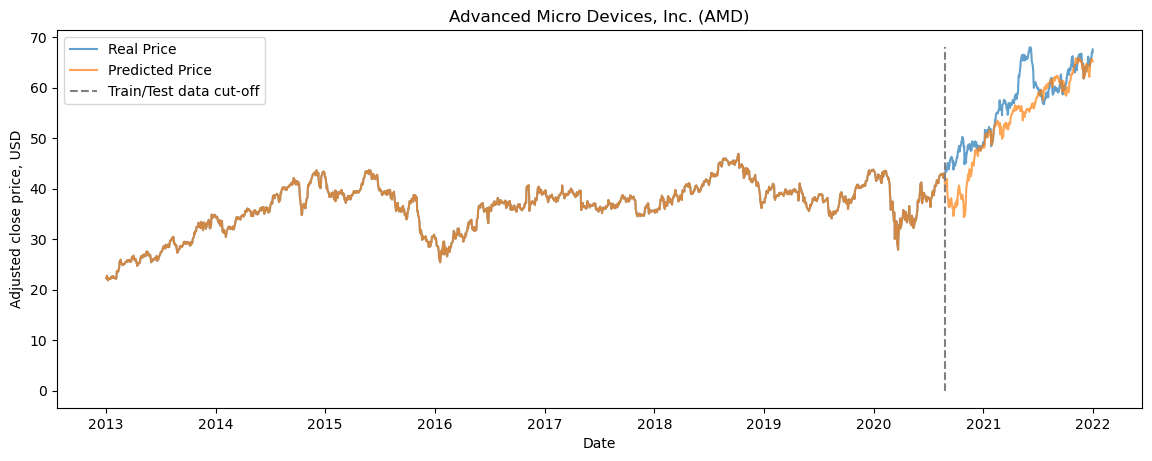

In [518]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df_char['Date'], df_char['Adj Close'], label='Real Price', alpha = 0.7)
plt.plot(df_char['Date'], df_char['Predicted Close'], label='Predicted Price', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
plt.savefig(f"pictures/company_stocks_model.png")
plt.show()

### Many-to-One Model GRU - stocks_dataset

In [968]:
tf.keras.backend.clear_session()

In [969]:
stocks_inputs = Input(shape=(1, X_train_stocks.shape [2]))
x = GRU(128, activation = "relu", return_sequences=True)(stocks_inputs)
x = GRU(64, activation = "relu", return_sequences=False)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.10)(x)
x = BatchNormalization()(x)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.10)(x)
x = BatchNormalization()(x)
stocks_outputs = Dense(1, activation = "linear")(x)

# kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), kernel_regularizer="l2"
# kernel_initializer='glorot_uniform'
model_stocks = Model(stocks_inputs, stocks_outputs)

In [970]:
model_stocks.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 86)]           0         
_________________________________________________________________
gru (GRU)                    (None, 1, 128)            82944     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)               

In [971]:
opt_adadelta = Adadelta(lr=0.01, rho=0.95, epsilon=1e-07, decay=0.0)
opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt_rmsprop =RMSprop(learning_rate=1e-2, decay=0.1)
opt_rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
epochs = 150
batch_size = 128
validation_split = 0.225
callbacks_name = "stocks_predictor_gru.keras"

In [972]:
model_stocks, history_stocks = compile_fit_model(X_train_stocks,y_train_company, \
                callbacks_name, model_stocks, opt_adam, epochs, batch_size, validation_split)

Epoch 1/150
12/12 [==============================] - 1s 42ms/step - loss: 0.6851 - mae: 0.6254 - val_loss: 0.0696 - val_mae: 0.2255
Epoch 2/150
12/12 [==============================] - 0s 11ms/step - loss: 0.3881 - mae: 0.4712 - val_loss: 0.0352 - val_mae: 0.1435
Epoch 3/150
12/12 [==============================] - 0s 10ms/step - loss: 0.3552 - mae: 0.4206 - val_loss: 0.0242 - val_mae: 0.1079
Epoch 4/150
12/12 [==============================] - 0s 11ms/step - loss: 0.3031 - mae: 0.3648 - val_loss: 0.0188 - val_mae: 0.0838
Epoch 5/150
12/12 [==============================] - 0s 11ms/step - loss: 0.2829 - mae: 0.3530 - val_loss: 0.0162 - val_mae: 0.0674
Epoch 6/150
12/12 [==============================] - 0s 9ms/step - loss: 0.2325 - mae: 0.3234 - val_loss: 0.0157 - val_mae: 0.0652
Epoch 7/150
12/12 [==============================] - 0s 11ms/step - loss: 0.1942 - mae: 0.2857 - val_loss: 0.0157 - val_mae: 0.0656
Epoch 8/150
12/12 [==============================] - 0s 11ms/step - loss: 0.1

Epoch 63/150
12/12 [==============================] - 0s 11ms/step - loss: 0.0109 - mae: 0.0470 - val_loss: 0.0132 - val_mae: 0.0637
Epoch 64/150
12/12 [==============================] - 0s 8ms/step - loss: 0.0114 - mae: 0.0494 - val_loss: 0.0134 - val_mae: 0.0649
Epoch 65/150
12/12 [==============================] - 0s 16ms/step - loss: 0.0102 - mae: 0.0428 - val_loss: 0.0127 - val_mae: 0.0611
Epoch 66/150
12/12 [==============================] - 0s 11ms/step - loss: 0.0102 - mae: 0.0416 - val_loss: 0.0125 - val_mae: 0.0600
Epoch 67/150
12/12 [==============================] - 0s 8ms/step - loss: 0.0103 - mae: 0.0424 - val_loss: 0.0128 - val_mae: 0.0627
Epoch 68/150
12/12 [==============================] - 0s 9ms/step - loss: 0.0101 - mae: 0.0414 - val_loss: 0.0127 - val_mae: 0.0630
Epoch 69/150
12/12 [==============================] - 0s 13ms/step - loss: 0.0104 - mae: 0.0429 - val_loss: 0.0123 - val_mae: 0.0603
Epoch 70/150
12/12 [==============================] - 0s 10ms/step - los

Epoch 125/150
12/12 [==============================] - 0s 7ms/step - loss: 0.0086 - mae: 0.0355 - val_loss: 0.0098 - val_mae: 0.0552
Epoch 126/150
12/12 [==============================] - 0s 7ms/step - loss: 0.0088 - mae: 0.0373 - val_loss: 0.0093 - val_mae: 0.0493
Epoch 127/150
12/12 [==============================] - 0s 7ms/step - loss: 0.0085 - mae: 0.0354 - val_loss: 0.0085 - val_mae: 0.0440
Epoch 128/150
12/12 [==============================] - 0s 7ms/step - loss: 0.0082 - mae: 0.0336 - val_loss: 0.0077 - val_mae: 0.0352
Epoch 129/150
12/12 [==============================] - 0s 8ms/step - loss: 0.0086 - mae: 0.0360 - val_loss: 0.0072 - val_mae: 0.0292
Epoch 130/150
12/12 [==============================] - 0s 6ms/step - loss: 0.0085 - mae: 0.0355 - val_loss: 0.0097 - val_mae: 0.0552
Epoch 131/150
12/12 [==============================] - 0s 7ms/step - loss: 0.0087 - mae: 0.0361 - val_loss: 0.0084 - val_mae: 0.0452
Epoch 132/150
12/12 [==============================] - 0s 7ms/step - 

In [973]:
model_stocks = load_model("stocks_predictor_gru.keras")
print(f"Test MAE: {model_stocks.evaluate(X_test_stocks, y_test_company)[1]:.2f}")

11/11 [==============================] - 0s 2ms/step - loss: 0.0139 - mean_absolute_error: 0.0724
Test MAE: 0.07


In [3]:
# model_stocks.layers[3].kernel.numpy().ravel()

In [2]:
# plt.figure()
# plt.hist(model_stocks.layers[3].kernel.numpy().ravel(), bins = 30, facecolor='g', alpha=0.6)
# plt.figure()
# plt.hist(model_stocks.layers[6].kernel.numpy().ravel(), bins = "fd", facecolor='g', alpha=0.6)
# plt.show()

In [976]:
hist = pd.DataFrame(history_stocks.history)
hist['epoch'] = history_stocks.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
145,0.008088,0.033950,0.007207,0.033818,145
146,0.007772,0.032126,0.006666,0.025966,146
147,0.008009,0.034678,0.006849,0.031218,147
148,0.007519,0.030539,0.007116,0.033860,148
149,0.007756,0.032476,0.007219,0.036317,149


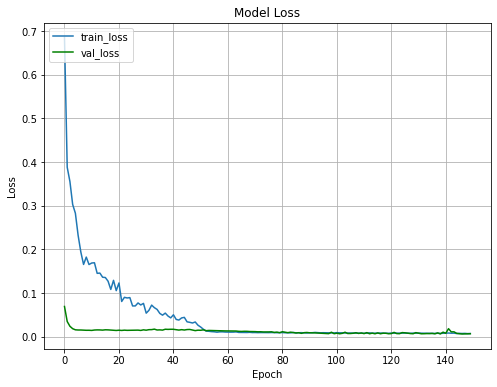

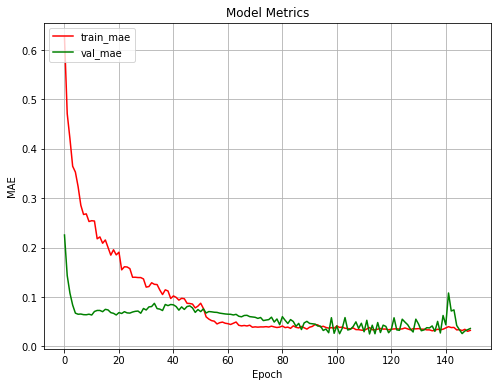

In [977]:
plot_history_loss(history_stocks), plot_mae(history_stocks)
plt.show()

In [978]:
predicted_stock_price = model_stocks.predict([X_test_stocks])

In [979]:
real_df = pd.DataFrame(full_df_train.iloc[:, 0:1])
predicted_df = pd.DataFrame(company_df.iloc[1926:, [0, 1]])
predicted_df["Predicted Close"] = min_max_normalize_inverse_transform(predicted_stock_price, MIN, MAX).reshape(1,len(predicted_stock_price))[0]
before_df = pd.DataFrame(company_df.iloc[0:1926, 0:2])
before_df["Predicted Close"] = before_df["Adj Close"]
df_char = pd.concat([before_df, predicted_df])
df_char["Year"] = pd.DatetimeIndex(df_char['Date']).year
df_char

,Date,Adj Close,Predicted Close,Year
0,2013-01-02,22.333015,22.333015,2013
1,2013-01-03,22.153860,22.153860,2013
2,2013-01-04,22.761452,22.761452,2013
3,2013-01-07,21.818907,21.818907,2013
4,2013-01-08,22.075964,22.075964,2013
...,...,...,...,...
2262,2021-12-27,66.070000,62.529091,2021
2263,2021-12-28,66.930000,62.146416,2021
2264,2021-12-29,67.010002,62.464371,2021
2265,2021-12-30,66.860001,62.148506,2021


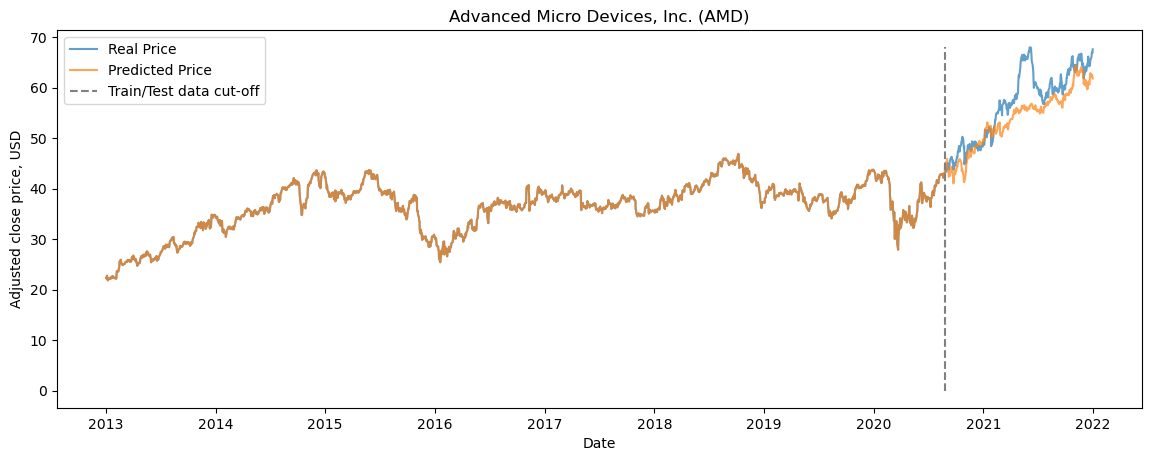

In [980]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df_char['Date'], df_char['Adj Close'], label='Real Price', alpha = 0.7)
plt.plot(df_char['Date'], df_char['Predicted Close'], label='Predicted Price', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
plt.savefig(f"pictures/company_stocks_model.png")
plt.show()

## 2. COMPANY Models - Architectures

### Many-to-One Base Model

In [367]:
tf.keras.backend.clear_session()

In [348]:
company_inputs = Input(shape=(1, X_train_company.shape [2]))
x  = Dense(128, activation='relu', kernel_initializer='normal', kernel_regularizer="l2")(company_inputs)
x  = Dropout(0.1)(x)
x  = BatchNormalization()(x)   
x  = Dense(64, activation='relu', kernel_initializer='normal', kernel_regularizer="l2")(x)
x  = Dropout(0.1)(x)
x  = BatchNormalization()(x)
x  = Dense(32, activation='relu', kernel_initializer='normal', kernel_regularizer="l2")(x)
x  = Dropout(0.1)(x)
x  = BatchNormalization()(x)
company_outputs = Dense(1)(x)  

model_company = Model(company_inputs, company_outputs)

In [349]:
model_company.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 42)]           0         
_________________________________________________________________
dense (Dense)                (None, 1, 128)            5504      
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 128)            512       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 64)             8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64)            

In [350]:
opt_adadelta = Adadelta(lr=0.01, rho=0.95, epsilon=1e-07, decay=0.0)
opt_adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
opt_rmsprop =RMSprop(learning_rate=1e-2, decay=0.1)
opt_rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
epochs = 120
batch_size = 128
validation_split = 0.25

In [351]:
model_company, history_company = compile_fit_model(X_train_company,y_train_company, \
                "company_predictor_base.keras", model_company, opt_rmsprop, epochs, batch_size, validation_split)

Epoch 1/120
12/12 [==============================] - 0s 29ms/step - loss: 1.8863 - mae: 0.7018 - val_loss: 0.4268 - val_mae: 0.1057
Epoch 2/120
12/12 [==============================] - 0s 7ms/step - loss: 0.5368 - mae: 0.2670 - val_loss: 0.3840 - val_mae: 0.1057
Epoch 3/120
12/12 [==============================] - 0s 6ms/step - loss: 0.4620 - mae: 0.2256 - val_loss: 0.3466 - val_mae: 0.1030
Epoch 4/120
12/12 [==============================] - 0s 7ms/step - loss: 0.4270 - mae: 0.2207 - val_loss: 0.3062 - val_mae: 0.0838
Epoch 5/120
12/12 [==============================] - 0s 6ms/step - loss: 0.3623 - mae: 0.1927 - val_loss: 0.2658 - val_mae: 0.0704
Epoch 6/120
12/12 [==============================] - 0s 7ms/step - loss: 0.3345 - mae: 0.1922 - val_loss: 0.2282 - val_mae: 0.0659
Epoch 7/120
12/12 [==============================] - 0s 7ms/step - loss: 0.2865 - mae: 0.1749 - val_loss: 0.1942 - val_mae: 0.0670
Epoch 8/120
12/12 [==============================] - 0s 7ms/step - loss: 0.2418 - 

12/12 [==============================] - 0s 15ms/step - loss: 0.0244 - mae: 0.0535 - val_loss: 0.0159 - val_mae: 0.0563
Epoch 64/120
12/12 [==============================] - 0s 11ms/step - loss: 0.0236 - mae: 0.0549 - val_loss: 0.0144 - val_mae: 0.0468
Epoch 65/120
12/12 [==============================] - 0s 8ms/step - loss: 0.0234 - mae: 0.0533 - val_loss: 0.0147 - val_mae: 0.0498
Epoch 66/120
12/12 [==============================] - 0s 13ms/step - loss: 0.0221 - mae: 0.0514 - val_loss: 0.0139 - val_mae: 0.0440
Epoch 67/120
12/12 [==============================] - 0s 13ms/step - loss: 0.0222 - mae: 0.0512 - val_loss: 0.0139 - val_mae: 0.0461
Epoch 68/120
12/12 [==============================] - 0s 12ms/step - loss: 0.0236 - mae: 0.0524 - val_loss: 0.0137 - val_mae: 0.0445
Epoch 69/120
12/12 [==============================] - 0s 9ms/step - loss: 0.0221 - mae: 0.0507 - val_loss: 0.0131 - val_mae: 0.0411
Epoch 70/120
12/12 [==============================] - 0s 6ms/step - loss: 0.0218 - m

In [352]:
model_company.evaluate(X_test_company, y_test_company)

11/11 [==============================] - 0s 907us/step - loss: 0.0130 - mae: 0.1013


[0.013001734390854836, 0.10129932314157486]

In [353]:
print(f"Test MAE: {model_company.evaluate(X_test_company, y_test_company)[1]:.2f}")

11/11 [==============================] - 0s 1ms/step - loss: 0.0130 - mae: 0.1013
Test MAE: 0.10


In [354]:
hist = pd.DataFrame(history_company.history)
hist['epoch'] = history_company.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
115,0.003017,0.019771,0.002688,0.015626,115
116,0.002903,0.019389,0.002684,0.016744,116
117,0.002792,0.019478,0.002368,0.011352,117
118,0.002723,0.019248,0.002587,0.020440,118
119,0.002663,0.019597,0.002750,0.025600,119


(None, None)

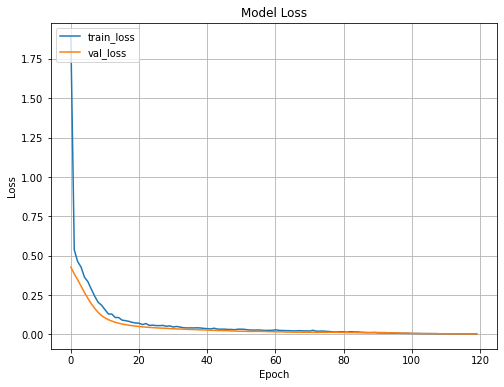

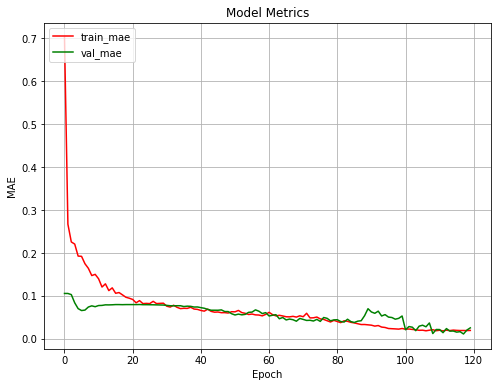

In [355]:
plot_history_loss(history_company), plot_mae(history_company)

In [364]:
predicted_stock_price = model_company.predict([X_test_company])

In [365]:
real_df = pd.DataFrame(full_df_train.iloc[:, 0:1])
predicted_df = pd.DataFrame(company_df.iloc[1926:, [0, 1]])
predicted_df["Predicted Close"] = min_max_normalize_inverse_transform(predicted_stock_price, MIN, MAX).reshape(1,len(predicted_stock_price))[0]
predicted_df

,Date,Adj Close,Predicted Close
1926,2020-08-26,43.117249,41.873531
1927,2020-08-27,43.349895,41.972301
1928,2020-08-28,43.524384,42.108154
1929,2020-08-31,43.388668,42.148552
1930,2020-09-01,43.757027,42.335434
...,...,...,...
2262,2021-12-27,66.070000,60.603714
2263,2021-12-28,66.930000,60.787834
2264,2021-12-29,67.010002,60.927597
2265,2021-12-30,66.860001,60.989273


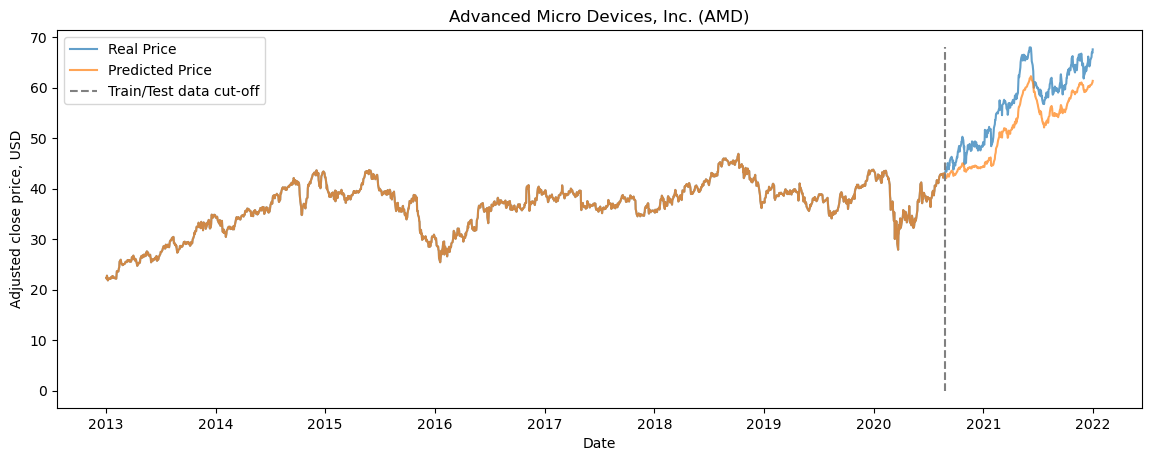

In [366]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df_char['Date'], df_char['Adj Close'], label='Real Price', alpha = 0.7)
plt.plot(df_char['Date'], df_char['Predicted Close'], label='Predicted Price', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
plt.savefig(f"pictures/company_base_model.png")
plt.show()

### Many-to-One LSTM Model

In [942]:
tf.keras.backend.clear_session()

In [943]:
company_inputs = Input(shape=(1, X_train_company.shape [2]))
x = LSTM(128, activation = "relu", return_sequences=True)(company_inputs)
x = LSTM(64, activation = "relu", return_sequences=True)(x)
x = LSTM(32, activation = "relu",return_sequences=True)(x)
x = LSTM(16, activation = "relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), return_sequences=True)(x)
x = LSTM(32, activation = "relu", return_sequences=True)(x)
x = LSTM(16, activation = "relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), return_sequences=False)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.10)(x)
company_outputs = Dense(1, activation='linear')(x)

model_company = Model(company_inputs, company_outputs)

In [944]:
model_company.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 42)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            87552     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             3136      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 32)             6272      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)               

In [945]:
opt_adadelta = Adadelta(lr=0.01, rho=0.95, epsilon=1e-07, decay=0.0)
opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
opt_rmsprop =RMSprop(learning_rate=1e-2, decay=0.1)
opt_rms = RMSprop(lr=0.001, rho=0.90, epsilon=1e-07, decay=0.0)
epochs = 70
batch_size = 128
validation_split = 0.225

In [946]:
model_company, history_company = compile_fit_model(X_train_company,y_train_company, \
                "company_predictor_lstm.keras", model_company, opt_rms, epochs, batch_size, validation_split)

Epoch 1/70
12/12 [==============================] - 1s 76ms/step - loss: 0.0807 - mae: 0.2384 - val_loss: 0.0482 - val_mae: 0.1733
Epoch 2/70
12/12 [==============================] - 0s 13ms/step - loss: 0.0334 - mae: 0.1334 - val_loss: 0.0238 - val_mae: 0.1034
Epoch 3/70
12/12 [==============================] - 0s 14ms/step - loss: 0.0205 - mae: 0.0862 - val_loss: 0.0166 - val_mae: 0.0672
Epoch 4/70
12/12 [==============================] - 0s 15ms/step - loss: 0.0140 - mae: 0.0555 - val_loss: 0.0111 - val_mae: 0.0441
Epoch 5/70
12/12 [==============================] - 0s 14ms/step - loss: 0.0109 - mae: 0.0460 - val_loss: 0.0097 - val_mae: 0.0445
Epoch 6/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0094 - mae: 0.0434 - val_loss: 0.0102 - val_mae: 0.0593
Epoch 7/70
12/12 [==============================] - 0s 15ms/step - loss: 0.0078 - mae: 0.0366 - val_loss: 0.0080 - val_mae: 0.0469
Epoch 8/70
12/12 [==============================] - 0s 13ms/step - loss: 0.0070 - m

In [947]:
print(f"Test MAE: {model_company.evaluate(X_test_company, y_test_company)[1]:.2f}")

11/11 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0472
Test MAE: 0.05


In [948]:
hist = pd.DataFrame(history_company.history)
hist['epoch'] = history_company.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
65,0.001354,0.022314,0.001199,0.021517,65
66,0.001297,0.021398,0.001435,0.026478,66
67,0.001421,0.023613,0.001181,0.021684,67
68,0.001312,0.021777,0.001621,0.030127,68
69,0.001364,0.022892,0.001039,0.019023,69


(None, None)

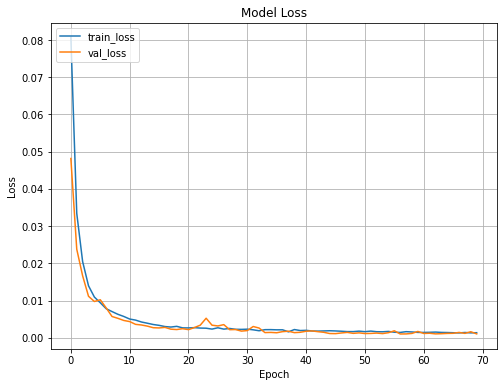

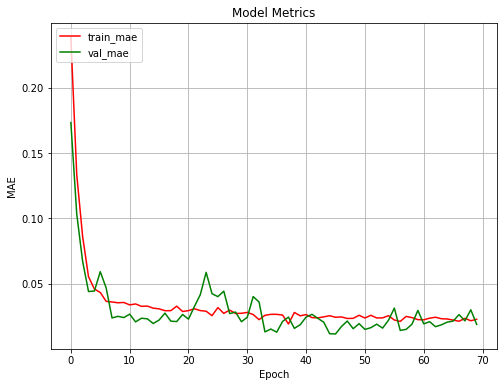

In [949]:
plot_history_loss(history_company), plot_mae(history_company)

In [950]:
predicted_stock_price = model_company.predict([X_test_company])

In [951]:
real_df = pd.DataFrame(full_df_train.iloc[:, 0:1])
predicted_df = pd.DataFrame(company_df.iloc[1926:, [0, 1]])
predicted_df["Predicted Close"] = min_max_normalize_inverse_transform(predicted_stock_price, MIN, MAX).reshape(1,len(predicted_stock_price))[0]
before_df = pd.DataFrame(company_df.iloc[0:1926, 0:2])
before_df["Predicted Close"] = before_df["Adj Close"]
df_char = pd.concat([before_df, predicted_df])
df_char["Year"] = pd.DatetimeIndex(df_char['Date']).year
df_char

,Date,Adj Close,Predicted Close,Year
0,2013-01-02,22.333015,22.333015,2013
1,2013-01-03,22.153860,22.153860,2013
2,2013-01-04,22.761452,22.761452,2013
3,2013-01-07,21.818907,21.818907,2013
4,2013-01-08,22.075964,22.075964,2013
...,...,...,...,...
2262,2021-12-27,66.070000,61.622444,2021
2263,2021-12-28,66.930000,61.979958,2021
2264,2021-12-29,67.010002,62.162971,2021
2265,2021-12-30,66.860001,62.201248,2021


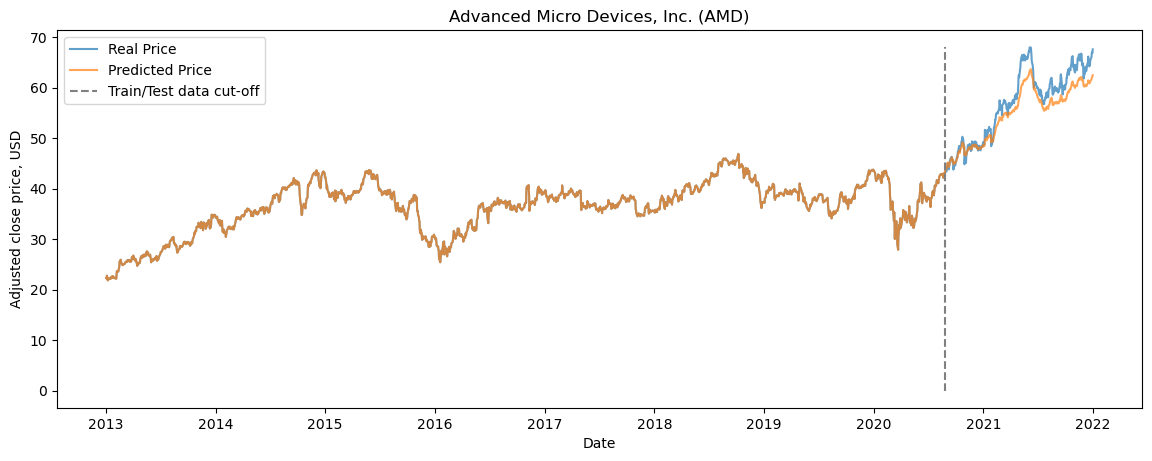

In [952]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df_char['Date'], df_char['Adj Close'], label='Real Price', alpha = 0.7)
plt.plot(df_char['Date'], df_char['Predicted Close'], label='Predicted Price', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
# plt.savefig(f"pictures/company_lstm_model.png")
plt.show()

### Many-to-One GRU Model

In [1514]:
tf.keras.backend.clear_session()

In [1515]:
company_inputs = Input(shape=(1, X_train_company.shape [2]))
x = GRU(128, activation = "relu", return_sequences=True)(company_inputs)
x = GRU(64, activation = "relu", return_sequences=True)(x)
x = GRU(64,  activation = "relu", return_sequences=True)(x)
x = GRU(32,  activation = "relu", return_sequences=True)(x)
x = GRU(32,  activation = "relu",  return_sequences=True)(x)
x = GRU(16,  activation = "relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), return_sequences=False)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.10)(x)

company_outputs = Dense(1,activation = "linear")(x)

model_company = Model(company_inputs, company_outputs)

In [1516]:
model_company.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 42)]           0         
_________________________________________________________________
gru (GRU)                    (None, 1, 128)            66048     
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 64)             37248     
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 64)             24960     
_________________________________________________________________
gru_3 (GRU)                  (None, 1, 32)             9408      
_________________________________________________________________
gru_4 (GRU)                  (None, 1, 32)             6336      
_________________________________________________________________
gru_5 (GRU)                  (None, 16)               

In [1517]:
opt_adadelta = Adadelta(lr=0.01, rho=0.95, epsilon=1e-07, decay=0.0)
opt_adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
opt_rmsprop =RMSprop(learning_rate=1e-2, decay=0.1)
opt_rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
epochs = 65
batch_size = 128
validation_split = 0.225

In [1518]:
model_company, history_company = compile_fit_model(X_train_company,y_train_company, \
                "company_predictor_gru.keras", model_company, opt_rms, epochs, batch_size, validation_split)

Epoch 1/65
12/12 [==============================] - 1s 79ms/step - loss: 0.0555 - mae: 0.1916 - val_loss: 0.0088 - val_mae: 0.0450
Epoch 2/65
12/12 [==============================] - 0s 12ms/step - loss: 0.0087 - mae: 0.0483 - val_loss: 0.0099 - val_mae: 0.0656
Epoch 3/65
12/12 [==============================] - 0s 20ms/step - loss: 0.0072 - mae: 0.0432 - val_loss: 0.0064 - val_mae: 0.0411
Epoch 4/65
12/12 [==============================] - 0s 17ms/step - loss: 0.0063 - mae: 0.0401 - val_loss: 0.0048 - val_mae: 0.0274
Epoch 5/65
12/12 [==============================] - 0s 14ms/step - loss: 0.0061 - mae: 0.0417 - val_loss: 0.0060 - val_mae: 0.0469
Epoch 6/65
12/12 [==============================] - 0s 15ms/step - loss: 0.0052 - mae: 0.0385 - val_loss: 0.0051 - val_mae: 0.0409
Epoch 7/65
12/12 [==============================] - 0s 13ms/step - loss: 0.0047 - mae: 0.0363 - val_loss: 0.0072 - val_mae: 0.0620
Epoch 8/65
12/12 [==============================] - 0s 13ms/step - loss: 0.0043 - m

In [1519]:
print(f"Test MAE: {model_company.evaluate(X_test_company, y_test_company)[1]:.2f}")

11/11 [==============================] - 0s 1ms/step - loss: 0.0029 - mae: 0.0447
Test MAE: 0.04


In [1520]:
hist = pd.DataFrame(history_company.history)
hist['epoch'] = history_company.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
60,0.001486,0.027028,0.002957,0.048279,60
61,0.001273,0.024136,0.001407,0.030105,61
62,0.001584,0.029044,0.001020,0.022812,62
63,0.001494,0.028579,0.001055,0.022307,63
64,0.001271,0.024853,0.001086,0.024068,64


(None, None)

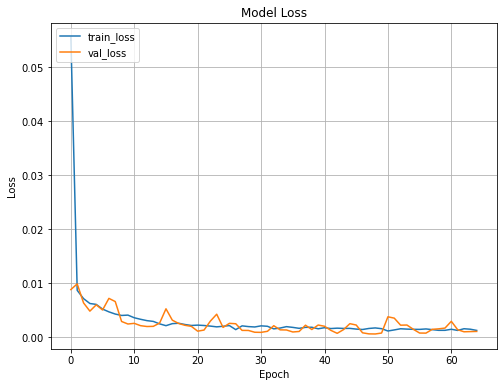

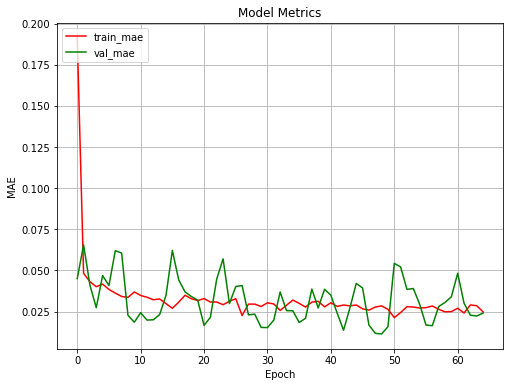

In [1521]:
plot_history_loss(history_company), plot_mae(history_company)

In [1522]:
predicted_stock_price = model_company.predict([X_test_company])

In [1523]:
real_df = pd.DataFrame(full_df_train.iloc[:, 0:1])
predicted_df = pd.DataFrame(company_df.iloc[1926:, [0, 1]])
predicted_df["Predicted Close"] = min_max_normalize_inverse_transform(predicted_stock_price, MIN, MAX).reshape(1,len(predicted_stock_price))[0]
before_df = pd.DataFrame(company_df.iloc[0:1926, 0:2])
before_df["Predicted Close"] = before_df["Adj Close"]
df_char = pd.concat([before_df, predicted_df])
df_char["Year"] = pd.DatetimeIndex(df_char['Date']).year
df_char

,Date,Adj Close,Predicted Close,Year
0,2013-01-02,22.333015,22.333015,2013
1,2013-01-03,22.153860,22.153860,2013
2,2013-01-04,22.761452,22.761452,2013
3,2013-01-07,21.818907,21.818907,2013
4,2013-01-08,22.075964,22.075964,2013
...,...,...,...,...
2262,2021-12-27,66.070000,65.794823,2021
2263,2021-12-28,66.930000,66.313797,2021
2264,2021-12-29,67.010002,66.616890,2021
2265,2021-12-30,66.860001,66.711563,2021


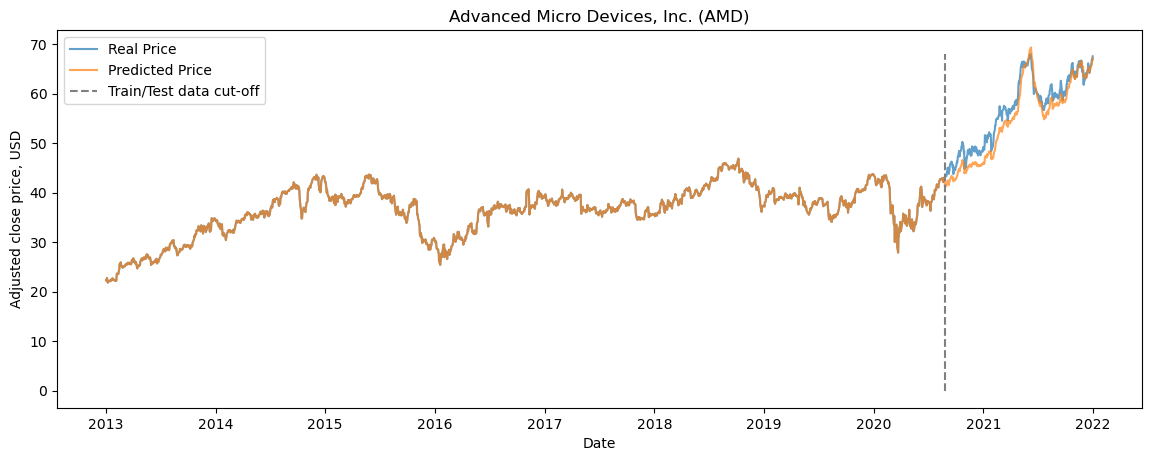

In [1525]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df_char['Date'], df_char['Adj Close'], label='Real Price', alpha = 0.7)
plt.plot(df_char['Date'], df_char['Predicted Close'], label='Predicted Price', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, company_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
# plt.savefig(f"pictures/company_gru_model.png")
plt.show()